In [3]:
import os

base_path = os.getcwd()
print("Current Notebook Path:", base_path)

dataset_path = os.path.join(base_path, "Real Life Violence Dataset")
print("Dataset Path:", dataset_path)

print("Folders inside dataset:", os.listdir(dataset_path))


Current Notebook Path: c:\Users\24ksh\OneDrive\Desktop\fight detection
Dataset Path: c:\Users\24ksh\OneDrive\Desktop\fight detection\Real Life Violence Dataset
Folders inside dataset: ['NonViolence', 'Violence']


In [4]:
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Use full absolute path (you can copy this from your File Explorer)
dataset_path = r"C:\Users\24ksh\OneDrive\Desktop\fight detection\Real Life Violence Dataset"
violence_dir = os.path.join(dataset_path, "Violence")
nonviolence_dir = os.path.join(dataset_path, "NonViolence")

print("Violence Dir Exists:", os.path.exists(violence_dir))
print("NonViolence Dir Exists:", os.path.exists(nonviolence_dir))


Violence Dir Exists: True
NonViolence Dir Exists: True


In [5]:
import os

base_path = os.getcwd()
print("Current Notebook Path:", base_path)

# If your notebook is in 'fight detection' and your dataset is directly inside 'fight detection',
# then base_path is already your project root.
# So, project_root_path should just be base_path.
project_root_path = base_path # Or just remove the project_root_path variable if it causes confusion

dataset_path = os.path.join(base_path, "Real Life Violence Dataset") # Use base_path directly
print("Dataset Path:", dataset_path)

print("Folders inside dataset:", os.listdir(dataset_path))

Current Notebook Path: c:\Users\24ksh\OneDrive\Desktop\fight detection
Dataset Path: c:\Users\24ksh\OneDrive\Desktop\fight detection\Real Life Violence Dataset
Folders inside dataset: ['NonViolence', 'Violence']


C:\Users\24ksh\AppData\Local\Temp\ipykernel_35360\3103617557.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Violence', 'NonViolence'],


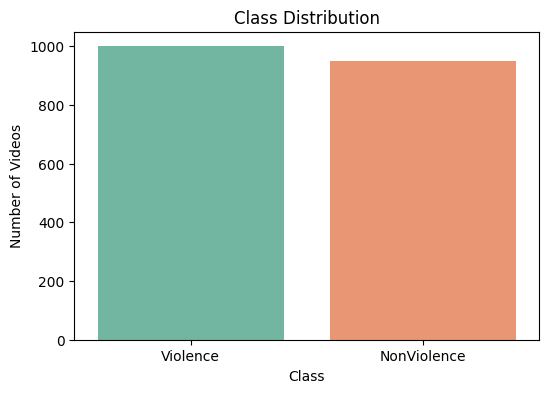

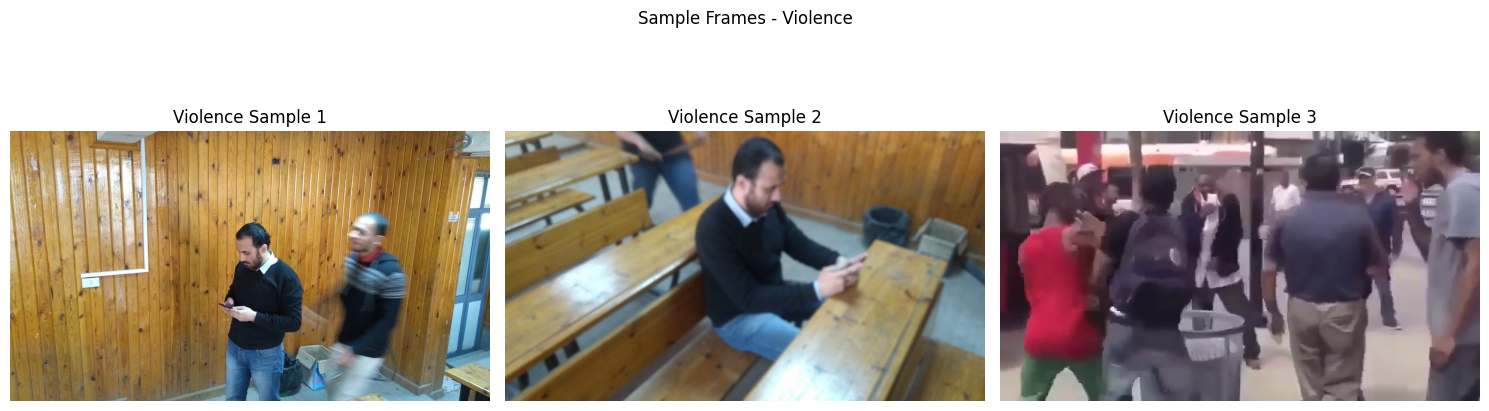

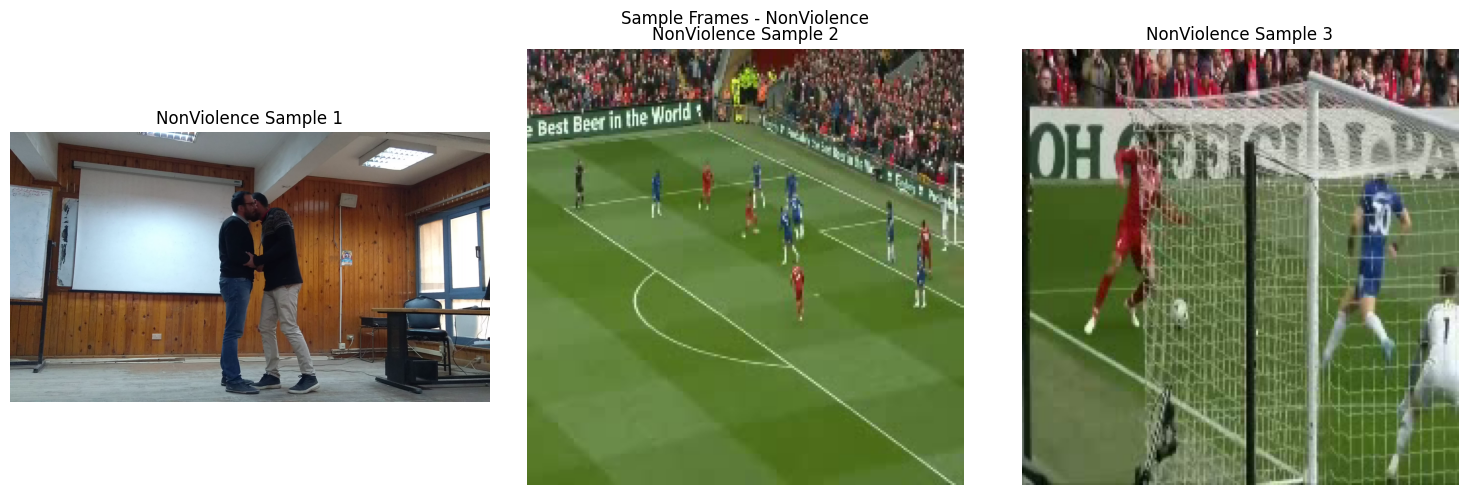

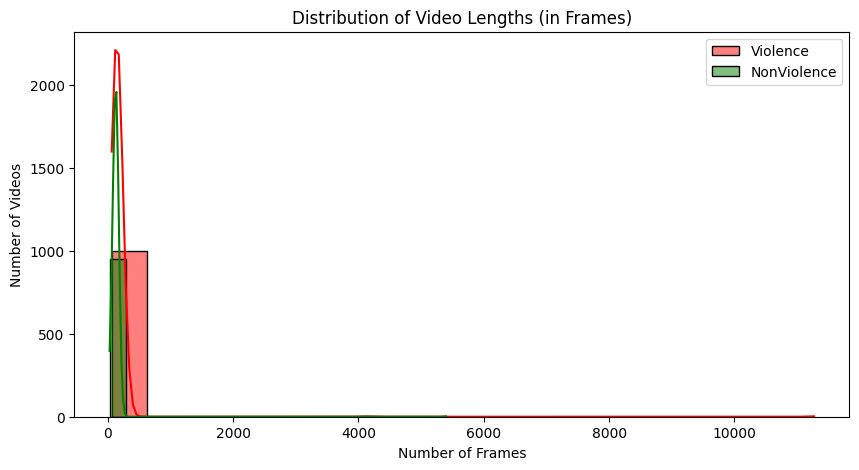

In [8]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Base dataset path
dataset_path = os.path.join(os.getcwd(), "Real Life Violence Dataset")
violence_dir = os.path.join(dataset_path, "Violence")
nonviolence_dir = os.path.join(dataset_path, "NonViolence")

# Collect video paths
violence_videos = glob(os.path.join(violence_dir, '*.mp4'))
nonviolence_videos = glob(os.path.join(nonviolence_dir, '*.mp4'))

# 1. Class Distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=['Violence', 'NonViolence'], 
            y=[len(violence_videos), len(nonviolence_videos)], 
            palette='Set2')
plt.title('Class Distribution')
plt.ylabel('Number of Videos')
plt.xlabel('Class')
plt.show()

# 2. Show Sample Frames
def show_sample_frames(video_paths, label, num_samples=3):
    plt.figure(figsize=(15, 5))
    for i, path in enumerate(video_paths[:num_samples]):
        cap = cv2.VideoCapture(path)
        ret, frame = cap.read()
        cap.release()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(frame)
            plt.axis('off')
            plt.title(f"{label} Sample {i+1}")
    plt.suptitle(f"Sample Frames - {label}")
    plt.tight_layout()
    plt.show()

# Show sample frames
show_sample_frames(violence_videos, "Violence")
show_sample_frames(nonviolence_videos, "NonViolence")

# 3. Video Duration (Frame Count) Distribution
def get_frame_counts(video_list):
    frame_counts = []
    for video in video_list:
        cap = cv2.VideoCapture(video)
        frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        frame_counts.append(frames)
    return frame_counts

violence_frames = get_frame_counts(violence_videos)
nonviolence_frames = get_frame_counts(nonviolence_videos)

plt.figure(figsize=(10, 5))
sns.histplot(violence_frames, color='red', label='Violence', kde=True, bins=20)
sns.histplot(nonviolence_frames, color='green', label='NonViolence', kde=True, bins=20)
plt.legend()
plt.xlabel('Number of Frames')
plt.ylabel('Number of Videos')
plt.title('Distribution of Video Lengths (in Frames)')
plt.show()


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf # Import TensorFlow for MobileNetV2 preprocessing

# Constants
NUM_FRAMES = 30  # Number of frames to extract per video
FRAME_SIZE = (224, 224)  # MobileNetV2 input size (height, width)
CLASSES = ['NonViolence', 'Violence']
LABEL_MAP = {'NonViolence': 0, 'Violence': 1}

dataset_path = os.path.join(os.getcwd(), "Real Life Violence Dataset")

# --- Function to preprocess a single video ---
def preprocess_video(video_path, num_frames=NUM_FRAMES, frame_size=FRAME_SIZE):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Handle cases with invalid or empty videos gracefully
    if not cap.isOpened() or total_frames < 1:
        print(f"Warning: Could not open or video is empty: {video_path}")
        cap.release()
        # Return a tensor of zeros to maintain shape, but consider logging or skipping
        return np.zeros((num_frames, frame_size[0], frame_size[1], 3), dtype=np.float32)

    # Evenly spaced frame indices
    # Using float for linspace and then converting to int for cleaner index selection
    frame_indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=np.int32)

    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx) # Set the current frame position
        ret, frame = cap.read() # Read the frame

        if ret:
            # Resize frame
            resized_frame = cv2.resize(frame, frame_size)
            # Apply MobileNetV2 specific preprocessing
            # It expects RGB (OpenCV reads BGR), so convert if necessary.
            # And expects float32 from 0-255 range.
            preprocessed_frame = tf.keras.applications.mobilenet_v2.preprocess_input(resized_frame.astype(np.float32))
            frames.append(preprocessed_frame)
        else:
            # If a frame can't be read, append an empty frame.
            # This can happen if total_frames was inaccurate or video is corrupt in parts.
            print(f"Warning: Could not read frame {idx} from {video_path}. Appending blank frame.")
            frames.append(np.zeros((frame_size[0], frame_size[1], 3), dtype=np.float32))

    cap.release()

    # Ensure exactly `num_frames` are returned.
    # If video had fewer actual readable frames than NUM_FRAMES, pad with zeros.
    # If more were read due to edge cases (unlikely with linspace but good for robustness), truncate.
    if len(frames) < num_frames:
        padding = np.zeros((num_frames - len(frames), *frame_size, 3), dtype=np.float32)
        frames.extend(padding.tolist())
    elif len(frames) > num_frames:
        frames = frames[:num_frames]

    return np.array(frames)


# --- Function to load and preprocess the entire dataset ---
def load_and_preprocess_dataset():
    all_video_tensors = []
    all_labels = []

    for label in CLASSES:
        folder_path = os.path.join(dataset_path, label)
        if not os.path.exists(folder_path):
            print(f"Error: Folder not found: {folder_path}. Skipping.")
            continue

        video_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp4')] # .lower() for case insensitivity
        if not video_files:
            print(f"Warning: No .mp4 files found in {folder_path}. Skipping.")
            continue

        for video_file in tqdm(video_files, desc=f"Processing {label} videos"):
            video_path = os.path.join(folder_path, video_file)
            video_tensor = preprocess_video(video_path)
            all_video_tensors.append(video_tensor)
            all_labels.append(LABEL_MAP[label])

    return np.array(all_video_tensors), np.array(all_labels)

# Run preprocessing
X, y = load_and_preprocess_dataset()
print("\nPreprocessing Complete!") # Added newline for cleaner output
print("X shape (videos, frames, height, width, channels):", X.shape)
print("y shape:", y.shape)

Processing NonViolence videos:  30%|███       | 288/951 [01:57<16:14,  1.47s/it]

Processing NonViolence videos:  31%|███       | 292/951 [02:02<15:28,  1.41s/it]

Processing NonViolence videos:  31%|███       | 294/951 [02:06<18:12,  1.66s/it]

Processing Violence videos:  78%|███████▊  | 779/1000 [07:22<03:30,  1.05it/s]

Processing Violence videos: 100%|██████████| 1000/1000 [08:54<00:00,  1.87it/s]


MemoryError: Unable to allocate 32.8 GiB for an array with shape (1951, 30, 224, 224, 3) and data type float32

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split 
import math 

# --- Constants ---
NUM_FRAMES = 30  # Number of frames to extract per video
FRAME_SIZE = (224, 224)  # MobileNetV2 input size (height, width)
BATCH_SIZE = 4 # Number of videos to process in one batch
CLASSES = ['NonViolence', 'Violence']
LABEL_MAP = {'NonViolence': 0, 'Violence': 1}

dataset_path = os.path.join(os.getcwd(), "Real Life Violence Dataset")

# --- Function to preprocess a single video ---
# This function is the same as before, it processes ONE video at a time.
# It will be called by the data generator.
def preprocess_video(video_path, num_frames=NUM_FRAMES, frame_size=FRAME_SIZE):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if not cap.isOpened() or total_frames < 1:
        # print(f"Warning: Could not open or video is empty: {video_path}") # Uncomment for debugging specific videos
        cap.release()
        return np.zeros((num_frames, frame_size[0], frame_size[1], 3), dtype=np.float32)

    # Evenly spaced frame indices
    # Using float for linspace and then converting to int for cleaner index selection
    frame_indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=np.int32)

    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx) # Set the current frame position
        ret, frame = cap.read() # Read the frame

        if ret:
            # Resize frame
            resized_frame = cv2.resize(frame, frame_size)
            # Apply MobileNetV2 specific preprocessing
            # OpenCV reads BGR, MobileNetV2 expects RGB. Convert before preprocessing.
            rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
            preprocessed_frame = tf.keras.applications.mobilenet_v2.preprocess_input(rgb_frame.astype(np.float32))
            frames.append(preprocessed_frame)
        else:
            # If a frame can't be read, append an empty frame.
            # print(f"Warning: Could not read frame {idx} from {video_path}. Appending blank frame.") # Uncomment for debugging
            frames.append(np.zeros((frame_size[0], frame_size[1], 3), dtype=np.float32))

    cap.release()

    # Ensure exactly `num_frames` are returned.
    if len(frames) < num_frames:
        padding = np.zeros((num_frames - len(frames), *frame_size, 3), dtype=np.float32)
        frames.extend(padding.tolist())
    elif len(frames) > num_frames:
        frames = frames[:num_frames] # Should not happen with linspace but for robustness

    return np.array(frames)


# --- Step 1: Create a list of all video paths and labels ---
print("--- Step 1: Collecting all video file paths and labels ---")
all_video_paths = []
all_labels = []

for label_name in CLASSES:
    folder_path = os.path.join(dataset_path, label_name)
    if not os.path.exists(folder_path):
        print(f"Error: Folder not found: {folder_path}. Skipping '{label_name}' class.")
        continue

    # Get all .mp4 files in the folder (case-insensitive)
    files_in_folder = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith('.mp4')]
    
    all_video_paths.extend(files_in_folder)
    all_labels.extend([LABEL_MAP[label_name]] * len(files_in_folder))

print(f"Total videos found across all classes: {len(all_video_paths)}")
print(f"Labels collected: {len(all_labels)}")

# Convert to numpy arrays for easier splitting
all_video_paths = np.array(all_video_paths)
all_labels = np.array(all_labels)

# --- Step 2: Split the data (paths and labels) into train/val/test sets ---
print("\n--- Step 2: Splitting data into training, validation, and test sets ---")
# Using 80/10/10 split (train/val/test) as a common practice
# stratify=labels ensures that the proportion of classes is maintained in each split
X_train_paths, X_temp_paths, y_train_labels, y_temp_labels = train_test_split(
    all_video_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)
X_val_paths, X_test_paths, y_val_labels, y_test_labels = train_test_split(
    X_temp_paths, y_temp_labels, test_size=0.5, random_state=42, stratify=y_temp_labels
)

print(f"Train videos: {len(X_train_paths)}")
print(f"Validation videos: {len(X_val_paths)}")
print(f"Test videos: {len(X_test_paths)}")


# --- Step 3: Define the Custom Data Generator (Keras Sequence) ---
print("\n--- Step 3: Defining and instantiating VideoDataGenerator ---")
class VideoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_paths, labels, batch_size=BATCH_SIZE,
                 num_frames=NUM_FRAMES, frame_size=FRAME_SIZE, shuffle=True):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.frame_size = frame_size
        self.shuffle = shuffle
        self.on_epoch_end() # Call this to initialize indices on startup

    def __len__(self):
        # Denotes the number of batches per epoch
        return math.ceil(len(self.video_paths) / self.batch_size) # Use math.ceil to include partial batches

    def __getitem__(self, index):
        # Generate indices of the batch
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get list of video paths and labels for this batch
        batch_video_paths = [self.video_paths[k] for k in indices]
        batch_labels = [self.labels[k] for k in indices]

        # Generate data for this batch
        X_batch, y_batch = self.__data_generation(batch_video_paths, batch_labels)
        return X_batch, y_batch

    def on_epoch_end(self):
        # Updates indices after each epoch for shuffling
        self.indices = np.arange(len(self.video_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_video_paths, batch_labels):
        # X is (batch_size, num_frames, height, width, channels)
        X = np.empty((len(batch_video_paths), self.num_frames, self.frame_size[0], self.frame_size[1], 3), dtype=np.float32)
        y = np.empty((len(batch_video_paths)), dtype=np.int32) # Labels are integer (0 or 1)

        # Loop through video paths in the current batch and preprocess each
        for i, video_path in enumerate(batch_video_paths):
            X[i,] = preprocess_video(video_path, self.num_frames, self.frame_size)
            y[i] = batch_labels[i]
        
        return X, y

# Instantiate the data generators for each split
train_generator = VideoDataGenerator(X_train_paths, y_train_labels, batch_size=BATCH_SIZE, shuffle=True)
validation_generator = VideoDataGenerator(X_val_paths, y_val_labels, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle validation
test_generator = VideoDataGenerator(X_test_paths, y_test_labels, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle test

print("\nData generators created successfully. RAM will NOT crash during this step!")
print("You can now use these generators to train your Keras model with `model.fit()`.")
print(f"Example: `model.fit(train_generator, epochs=10, validation_data=validation_generator, workers={os.cpu_count()}, use_multiprocessing=True)`")

# Optional: Verify a batch shape (this will load one batch to check)
try:
    print("\nVerifying one batch from training generator...")
    sample_X_batch, sample_y_batch = train_generator[0]
    print(f"Sample X_batch shape: {sample_X_batch.shape}")
    print(f"Sample y_batch shape: {sample_y_batch.shape}")
    print("Batch verification successful!")
except Exception as e:
    print(f"Error during batch verification: {e}")

--- Step 1: Collecting all video file paths and labels ---
Total videos found across all classes: 1951
Labels collected: 1951

--- Step 2: Splitting data into training, validation, and test sets ---
Train videos: 1560
Validation videos: 195
Test videos: 196

--- Step 3: Defining and instantiating VideoDataGenerator ---

Data generators created successfully. RAM will NOT crash during this step!
You can now use these generators to train your Keras model with `model.fit()`.
Example: `model.fit(train_generator, epochs=10, validation_data=validation_generator, workers=16, use_multiprocessing=True)`

Verifying one batch from training generator...
Sample X_batch shape: (4, 30, 224, 224, 3)
Sample y_batch shape: (4,)
Batch verification successful!


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, TimeDistributed, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- Constants (ensure these match your generator's constants) ---
NUM_FRAMES = 30
FRAME_SIZE = (224, 224)
NUM_CLASSES = 2 # Violent, Non-Violent (since LABEL_MAP maps to 0 and 1)

# 1. Load the pre-trained MobileNetV2 base model
# input_shape should match the shape of a single frame (height, width, channels)
base_model = MobileNetV2(input_shape=(FRAME_SIZE[0], FRAME_SIZE[1], 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the layers of the base model initially
base_model.trainable = False

# 2. Define the Model Architecture
# Input for our model will be a sequence of frames
# The shape is (None, NUM_FRAMES, FRAME_SIZE[0], FRAME_SIZE[1], 3)
# The 'None' indicates batch size, which is variable.
video_input = tf.keras.layers.Input(shape=(NUM_FRAMES, FRAME_SIZE[0], FRAME_SIZE[1], 3), name="video_input")

# Apply the base_model (MobileNetV2) to each frame in the sequence independently
# TimeDistributed applies a layer to every time step of an input tensor.
# The output of TimeDistributed(base_model) will be (batch_size, NUM_FRAMES, features_from_mobilenet_per_frame)
x = TimeDistributed(base_model, name="mobilenet_features_per_frame")(video_input)

# After getting features for each frame, we need to spatially pool them.
# GlobalAveragePooling2D reduces each feature map (e.g., 7x7) to a single value.
# Output shape: (batch_size, NUM_FRAMES, 1280) -> 1280 is the number of features from MobileNetV2's last layer
x = TimeDistributed(GlobalAveragePooling2D(), name="spatial_pooling_per_frame")(x)

# Temporal Modeling: Use an LSTM layer to learn temporal dependencies across the 30 frames.
# Bidirectional LSTM processes the sequence both forwards and backwards, potentially capturing more context.
x = Bidirectional(LSTM(128, return_sequences=False), name="bidirectional_lstm")(x) # return_sequences=False for the last LSTM layer
x = Dropout(0.5, name="dropout_lstm")(x) # Dropout for regularization

# Classification Head: Add dense layers for the final classification.
# The number of units in the last Dense layer should be equal to NUM_CLASSES.
# 'softmax' activation for multi-class classification.
output = Dense(NUM_CLASSES, activation='softmax', name="output_layer")(x)

# Create the Keras Model
model = Model(inputs=video_input, outputs=output, name="Violence_Detection_Model")

# 3. Compile the Model
# Using Adam optimizer with a learning rate suitable for initial training of the new layers
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # For integer labels (0 or 1)
              metrics=['accuracy']) # You can add more metrics like Precision, Recall

model.summary()


# --- Callbacks for Training ---
# Save the best model during training
checkpoint_filepath = 'best_violence_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # Save the entire model
    monitor='val_accuracy', # Monitor validation accuracy
    mode='max', # Save when val_accuracy is maximized
    save_best_only=True, # Only save the best model
    verbose=1
)

# Stop training if validation accuracy doesn't improve for a few epochs
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5, # Number of epochs with no improvement after which training will be stopped.
    mode='max',
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity.
    verbose=1
)





Model: "Violence_Detection_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 video_input (InputLayer)    [(None, 30, 224, 224, 3   0         
                             )]                                  
                                                                 
 mobilenet_features_per_fra  (None, 30, 7, 7, 1280)    2257984   
 me (TimeDistributed)                                            
                                                                 
 spatial_pooling_per_frame   (None, 30, 1280)          0         
 (TimeDistributed)                                               
                                                                 
 bidirectional_lstm (Bidire  (None, 256)               1442816   
 ctional)                                                        
                                                                 
 dropout_lstm (Dropout)      (None, 256)

In [12]:
print("hi")

hi


In [13]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    workers=4,  # adjust based on your system
    use_multiprocessing=False,  # safer to disable for now
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/10


390/390 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.8532
Epoch 1: val_accuracy improved from -inf to 0.92308, saving model to best_violence_model.h5


c:\Users\24ksh\OneDrive\Desktop\fight detection\movinet-env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


390/390 [==============================] - 936s 2s/step - loss: 0.3337 - accuracy: 0.8532 - val_loss: 0.1890 - val_accuracy: 0.9231
Epoch 2/10
390/390 [==============================] - ETA: 0s - loss: 0.1974 - accuracy: 0.9244
Epoch 2: val_accuracy improved from 0.92308 to 0.94359, saving model to best_violence_model.h5
390/390 [==============================] - 918s 2s/step - loss: 0.1974 - accuracy: 0.9244 - val_loss: 0.1275 - val_accuracy: 0.9436
Epoch 3/10
390/390 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9526
Epoch 3: val_accuracy improved from 0.94359 to 0.95897, saving model to best_violence_model.h5
390/390 [==============================] - 900s 2s/step - loss: 0.1217 - accuracy: 0.9526 - val_loss: 0.1037 - val_accuracy: 0.9590
Epoch 4/10
390/390 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.9526
Epoch 4: val_accuracy improved from 0.95897 to 0.96923, saving model to best_violence_model.h5
390/390 [======================

KeyboardInterrupt: 

In [14]:
from tensorflow.keras.models import load_model

# Load the best saved model (as saved during training)
model = load_model("best_violence_model.h5")  # or .keras if you used the modern format


In [15]:
# Evaluate on the test generator
test_loss, test_accuracy = model.evaluate(
    test_generator,
    workers=4,  # or adjust based on your system
    use_multiprocessing=False  # safer and works well in most environments
)

print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print(f"❌ Test Loss: {test_loss:.4f}")


49/49 [==============================] - 105s 2s/step - loss: 0.1407 - accuracy: 0.9388

✅ Test Accuracy: 0.9388
❌ Test Loss: 0.1407


In [1]:
# In your local environment where the model works
model.save("best_violence_model_clean.h5", include_optimizer=False)


NameError: name 'model' is not defined